In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import pandas as pd
import pickle

# Sarimax

In [ ]:
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
import warnings
warnings.filterwarnings("ignore")

traffic_2018 = pd.read_csv('trafficindex2018.csv')
traffic_2018['datetime'] = pd.to_datetime(traffic_2018['datetime'] + ' +07:00', format='%Y-%m-%dT%H:%M %z')
traffic_2019 = pd.read_csv('trafficindex2019.csv')
traffic_2019['datetime'] = pd.to_datetime(traffic_2019['datetime'] + ' +07:00', format='%Y-%m-%dT%H:%M %z')
traffic_2020 = pd.read_csv('trafficindex2020.csv')
traffic_2020['datetime'] = pd.to_datetime(traffic_2020['datetime'] + ' +07:00', format='%Y-%m-%dT%H:%M %z')
traffic_2021 = pd.read_csv('trafficindex2021.csv')
traffic_2021['datetime'] = pd.to_datetime(traffic_2021['datetime'] + ' +07:00', format='%Y-%m-%dT%H:%M %z')

all_traffic = pd.concat([traffic_2018, traffic_2019, traffic_2020, traffic_2021])
all_traffic['datetime'] = all_traffic['datetime'].dt.round('H')
all_traffic = all_traffic.groupby('datetime').mean()[['index']]
all_traffic.reset_index(inplace=True)
all_traffic['hour'] = all_traffic['datetime'].dt.hour
all_traffic['dayofweek'] = all_traffic['datetime'].dt.dayofweek
all_traffic['year'] = all_traffic['datetime'].dt.year
dummies_hour = pd.get_dummies(all_traffic['hour'], prefix='hour')
# dummies_year = pd.get_dummies(all_traffic['year'], prefix='year')
dummies_dayofweek = pd.get_dummies(all_traffic['dayofweek'], prefix='dayofweek')
all_traffic = pd.concat([all_traffic, dummies_hour, dummies_dayofweek], axis=1)
# all_traffic = pd.concat([all_traffic, dummies_hour, dummies_year, dummies_dayofweek], axis=1)
all_traffic.drop(columns=['hour', 'dayofweek', 'year'], inplace=True)
train_size = 24454
train = all_traffic[:train_size]
test = all_traffic[train_size:]

In [ ]:
# print('min_rmse :', min_rmse)
best_s = 12
print('best_s :', best_s)
order = (0, 1, 1)
ss_order = (1, 0, 1, best_s)
mod = SARIMAX(all_traffic['index'],
exog=all_traffic.drop(columns=['index', 'datetime']),
order=order,
seasonal_order=ss_order,
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()

best_s : 12


In [ ]:
model_file = open('sarimax.model', 'wb')
pickle.dump(results, model_file)
model_file.close()

In [ ]:
model_file = open('sarimax.model', 'rb')
sarimax_model = pickle.load(model_file)
model_file.close()

## LSTM

In [104]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(units = 72, activation = 'relu', input_shape = (72, 7)))
modelLSTM.add(Dropout(0.5))
modelLSTM.add(Dense(units = 72))

In [105]:
#create callback
filepath = 'my_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)

callbacks = [earlystopping, reduce_lr]

optimizer = Adam(learning_rate=0.0005)

def train_model(X_train, y_train, epochs=1):
  modelLSTM.compile(optimizer=optimizer, loss = 'mean_squared_error')
  trained = modelLSTM.fit(X_train, y_train, epochs=epochs, batch_size=32, callbacks=callbacks)
  return trained

In [106]:
def get_traffic(df):
  datetime_aq = df['datetime_aq'].unique()
  hours = pd.get_dummies(datetime_aq.hour, prefix='hour')
  dayofweeks = pd.get_dummies(datetime_aq.dayofweek, prefix='dayofweek')
  sarimax_input = pd.concat([hours, dayofweeks], axis=1)
  model_file = open('sarimax.model', 'rb')
  sarimax_model = pickle.load(model_file)
  model_file.close()
  traffic = sarimax_model.get_prediction(start=sarimax_input.index[0], end=sarimax_input.index[-1], exog=sarimax_input, dynamic=False).predicted_mean
  traffic[traffic < 0] = 0
  temp = pd.DataFrame({'datetime_aq':datetime_aq, 'traffic':traffic})
  df = df.merge(temp, left_on='datetime_aq', right_on='datetime_aq')
  return df

def prep_data(df, scaler):
  df = get_traffic(df)
  df = df[['pm25','temp','rh','pm10', 'lat','long', 'traffic']]
  arr = scaler.transform(df)
  inputs = []
  outputs = []
  validates = []
  for i in range(len(arr)//216):
    iov = arr[i*216:i*216+216]
    input = iov[:72]
    output = iov[72:144]
    validate = iov[144:]
    inputs.append(input)
    outputs.append(output)
    validates.append(validate)
  return np.array(inputs), np.array(outputs), np.array(validates)

In [107]:
df = pd.DataFrame()
for i in range(10):
  temp = pd.read_csv(f'dataset2_{i}.csv').rename(columns={'datetime':'datetime_aq'})
  temp['datetime_aq'] = pd.to_datetime(temp['datetime_aq'], format='%Y-%m-%d %H:%M:%S%z')
  temp = get_traffic(temp)
  df = pd.concat([df, temp])
df = df[['pm25','temp','rh','pm10', 'lat','long', 'traffic']]
scaler = MinMaxScaler()
scaler.fit(df)
import joblib
joblib.dump(scaler, 'scaler.gz')


['scaler.gz']

12/12 [==============================] - 2s 52ms/step - loss: 0.0033 - lr: 5.0000e-04


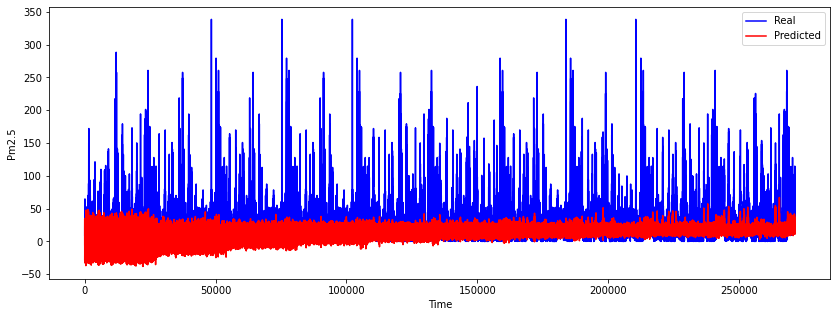

RMSE :  20.957884541030655
12/12 [==============================] - 2s 56ms/step - loss: 0.0023 - lr: 5.0000e-04


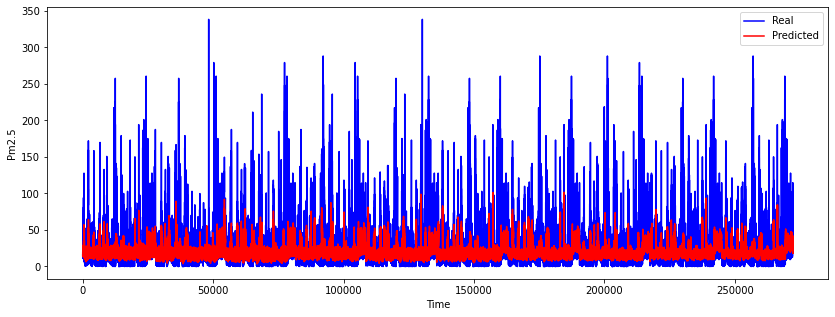

RMSE :  15.771073053715266
12/12 [==============================] - 1s 51ms/step - loss: 0.0020 - lr: 5.0000e-04


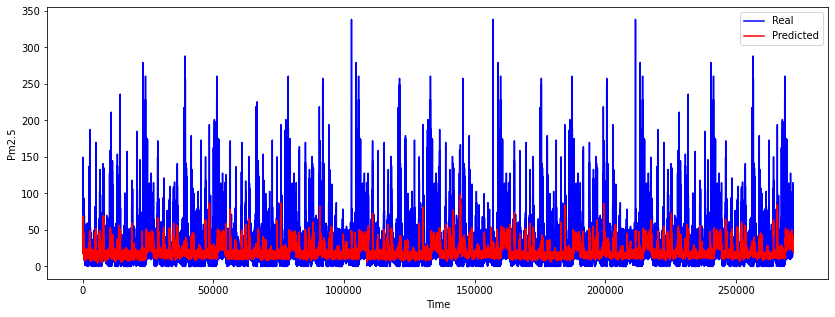

RMSE :  14.913373488661163
12/12 [==============================] - 1s 48ms/step - loss: 0.0018 - lr: 5.0000e-04


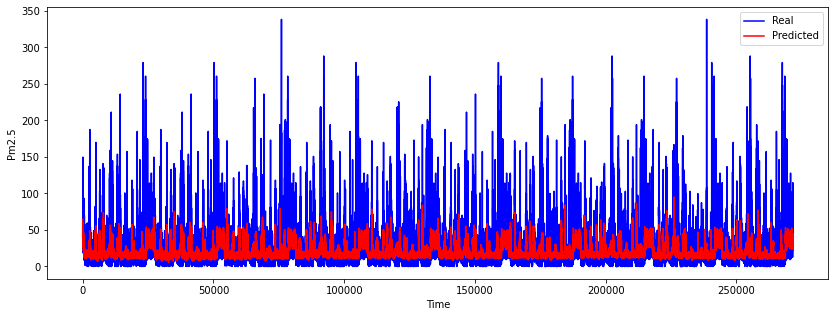

RMSE :  14.755170522629536
12/12 [==============================] - 2s 57ms/step - loss: 0.0019 - lr: 5.0000e-04


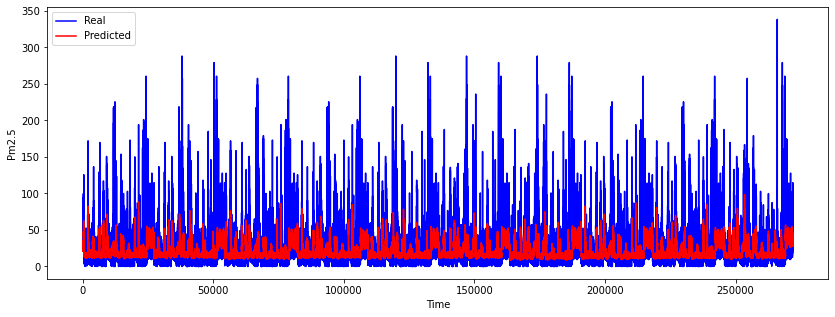

RMSE :  14.644363944229378
12/12 [==============================] - 2s 53ms/step - loss: 0.0018 - lr: 5.0000e-04


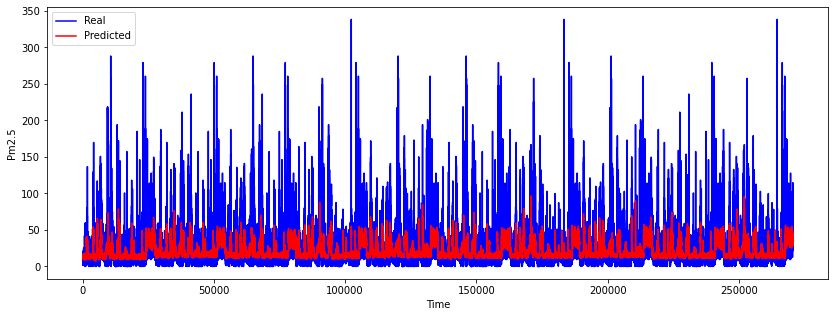

RMSE :  14.536489551362173
12/12 [==============================] - 2s 54ms/step - loss: 0.0019 - lr: 5.0000e-04


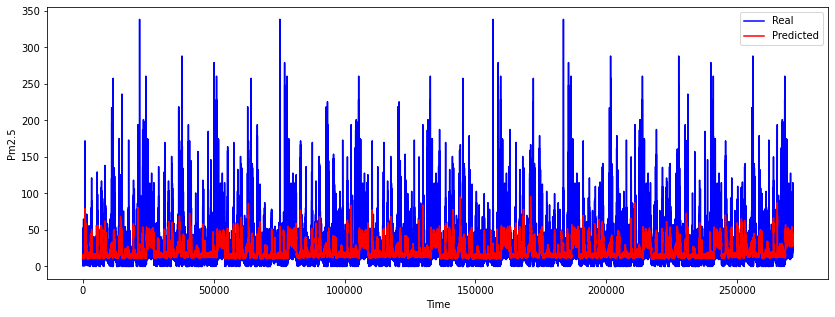

RMSE :  14.348255280286116
12/12 [==============================] - 1s 53ms/step - loss: 0.0018 - lr: 5.0000e-04


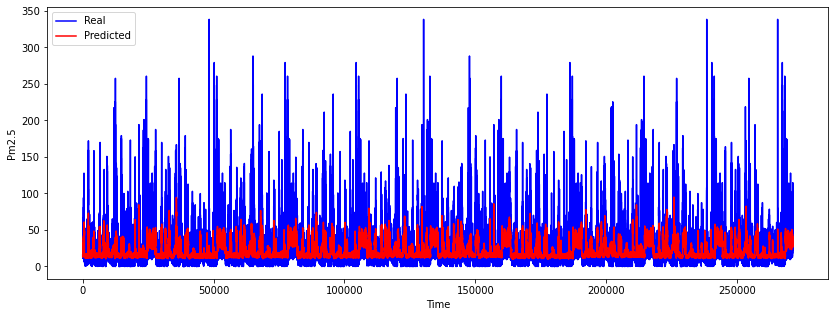

RMSE :  14.349770893340786
12/12 [==============================] - 2s 53ms/step - loss: 0.0016 - lr: 5.0000e-04


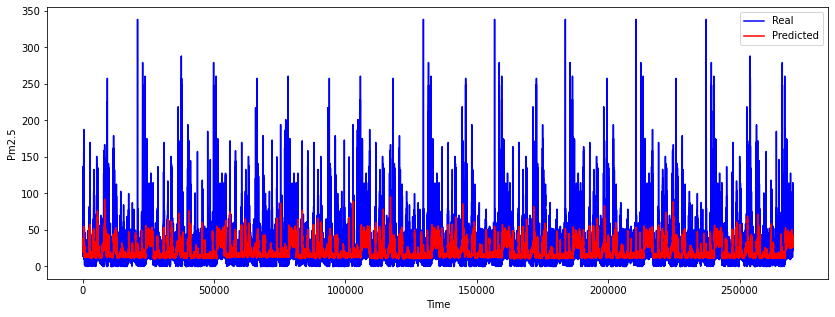

RMSE :  14.29513841292288
12/12 [==============================] - 2s 52ms/step - loss: 0.0018 - lr: 5.0000e-04


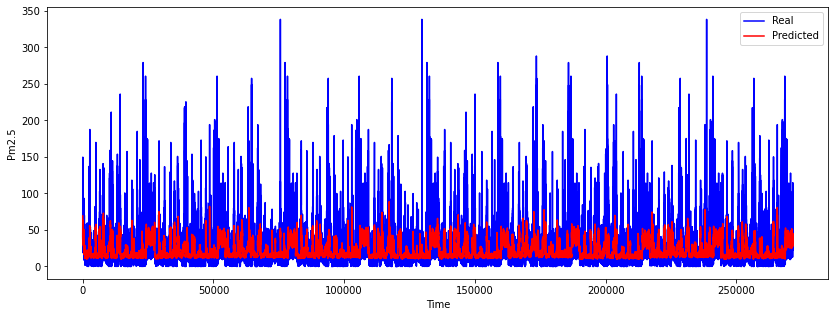

RMSE :  14.438217005658307


In [108]:
epochs = 10
min_rmse = 1e6
for i in range(epochs):
  np.random.seed(27 + i)
  selector = np.random.choice(np.arange(10), replace=True, size=10)
  acc_mse = 0
  yp_list = []
  yt_list = []
  for pidx in selector:
    df = pd.read_csv(f'dataset2_{pidx}.csv').rename(columns={'datetime':'datetime_aq'})
    df['datetime_aq'] = pd.to_datetime(df['datetime_aq'], format='%Y-%m-%d %H:%M:%S%z')
    inputs, outputs, validates = prep_data(df, scaler)
    train_model(inputs, outputs[:, :, 0], epochs=1)
    y_pred = modelLSTM.predict(outputs)
    scale = 1/scaler.scale_[0]
    y_pred = y_pred*scale
    y_test = validates[:, :, 0]*scale
    mse = mean_squared_error(y_test, y_pred)
    acc_mse += mse
    yp_list += y_pred.tolist()
    yt_list += y_test.tolist()
  plt.figure(figsize=(14,5))
  plt.plot(np.array(yt_list).reshape(-1), color = 'blue', label = 'Real')
  plt.plot(np.array(yp_list).reshape(-1), color = 'red', label = 'Predicted')
  plt.xlabel('Time')
  plt.ylabel('Pm2.5')
  plt.legend()
  plt.show()
  rmse = math.sqrt(acc_mse/epochs)
  print('RMSE : ', rmse)
  if rmse < min_rmse:
    modelLSTM.save('best_weight.h5')